In [1]:
!pip install tensorflow-gpu

    100% |████████████████████████████████| 345.2MB 59kB/s 


In [2]:
import sys
import cv2
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import exposure
import imutils

import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.applications import VGG16
from keras import layers
from keras import optimizers


from google.colab import files

# speed-up using multithreads
cv2.setUseOptimized(True);
cv2.setNumThreads(4);

from google.colab import drive
drive.mount('/content/gdrive')
!ls gdrive/My\ Drive/data/

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
mnistsample.png        test_images.pkl	 train_labels.csv
sample_submission.csv  train_images.pkl


In [0]:
def remove_background_noise(im):
    #stretch contrast to have only binary valued pixels
    processed = exposure.rescale_intensity(im, in_range=(1, 0))
    processed = cv2.cvtColor(processed,cv2.COLOR_GRAY2RGB)
    
    return processed
  

  
def get_bound_regions(im, method = 'f'):
    #see https://www.learnopencv.com/selective-search-for-object-detection-cpp-python/

    # create Selective Search Segmentation Object using default parameters
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # set input image on which we will run segmentation
    ss.setBaseImage(im)

    # Switch to fast but low recall Selective Search method
    if (method == 'f'):
        ss.switchToSelectiveSearchFast()

    # Switch to high recall but slow Selective Search method
    else:
        ss.switchToSelectiveSearchQuality()


    # run selective search segmentation on input image
    rects = ss.process()
    
    return rects
  
  
def get_best_regions(rects, img_dim, img_dim2):
    best_rect = None
    max_box_dim = 0   
    
    for rect in rects:
        max_dim = max(rect[2], rect[3])
        if max_dim > max_box_dim and max_dim < img_dim:
            max_box_dim = max_dim
            best_rect = rect
        
    return [best_rect] 
  

def get_best_regions2(rects, h, w):
    length = len(rects)
    return rects[0:min(length, 3)]
  
  
def display_image_with_bound(im, procesed, bound_regions, cropped):
    # create a copy of original image
    imOut = im.copy()

    for i, bound_region in enumerate(bound_regions):
        x, y, w, h = bound_region
        cv2.rectangle(imOut, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

    # show output
    plt.subplot(141),plt.imshow(im), plt.title('input')
    plt.subplot(142),plt.imshow(procesed), plt.title('processed')
    plt.subplot(143),plt.imshow(imOut), plt.title('result')
    plt.subplot(144),plt.imshow(cropped), plt.title('cropped/resized')
    plt.show()
  
  
  
#This method calls the above three and returns a (resized) cropped image
def find_best_bound_region(im_orig, display=False):
    
    im_processed = remove_background_noise(im_orig/255.0)
    bound_regions = get_bound_regions(im_processed)
    best_regions = get_best_regions(bound_regions, im_processed.shape[0], im_processed.shape[1])
    x,y,w,h = best_regions[0][0], best_regions[0][1], best_regions[0][2], best_regions[0][3]
    im_cropped = im_processed[y:y+h, x:x+w]
    image_resized = resize(im_cropped, (im_orig.shape[0], im_orig.shape[1]))
    if display:
        display_image_with_bound(im_orig, im_processed, best_regions, image_resized)
    return image_resized
  
  
 

In [0]:
X_data = pd.read_pickle('gdrive/My Drive/data/train_images.pkl')
y_data = pd.read_csv('gdrive/My Drive/data/train_labels.csv')
X_test = pd.read_pickle('gdrive/My Drive/data/test_images.pkl')

0 4


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


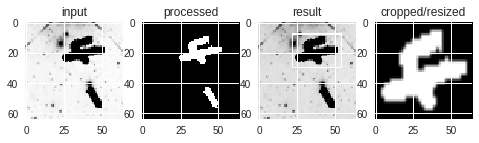

1 8


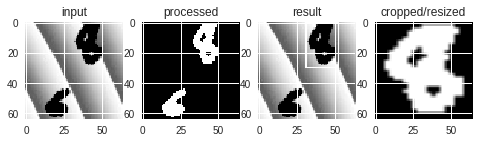

2 4


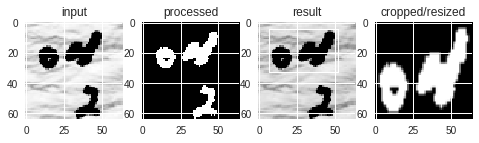

3 4


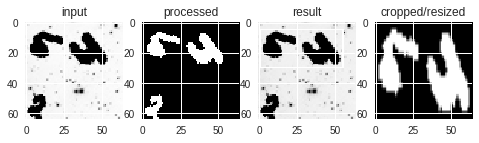

4 5


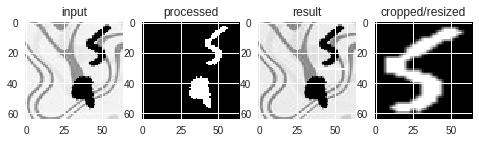

5 0


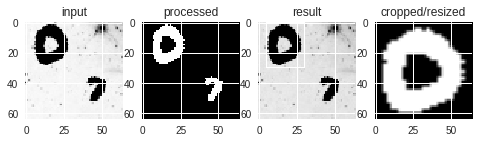

6 0


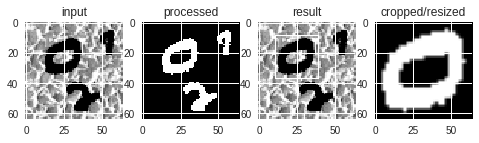

7 3


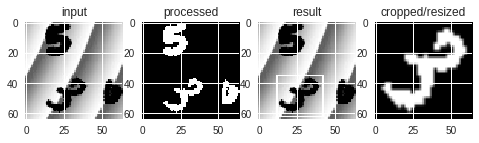

8 8


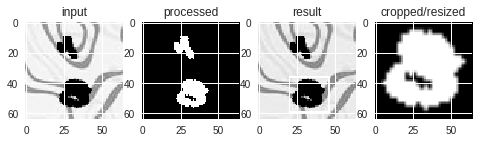

9 0


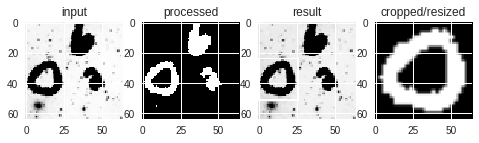

10 3


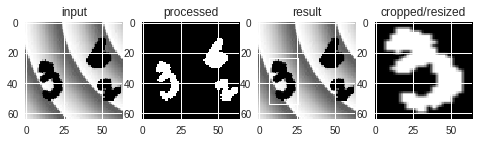

11 0


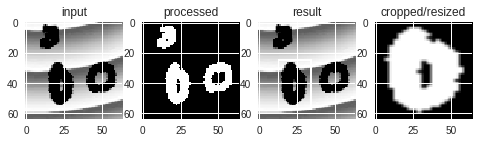

12 5


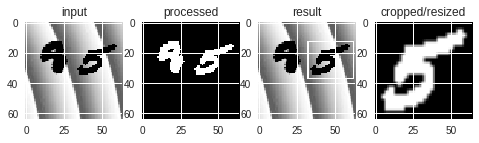

13 1


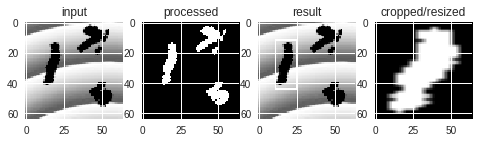

14 0


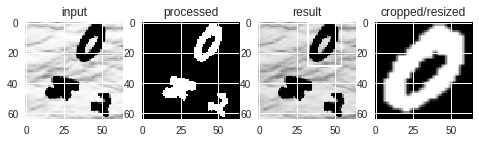

15 1


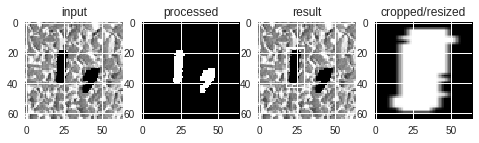

16 6


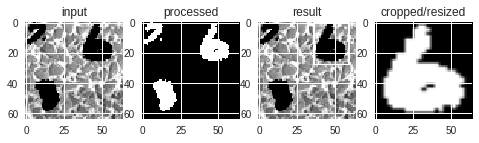

17 8


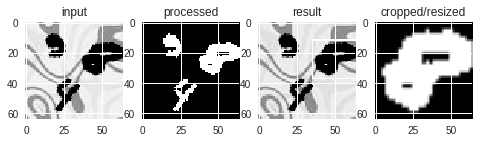

18 2


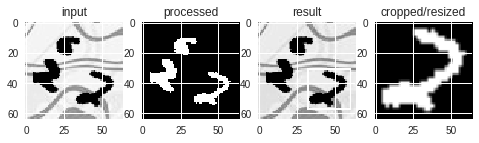

19 0


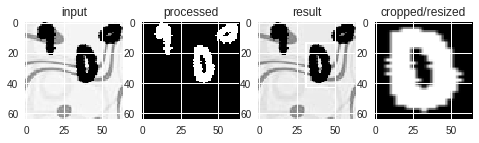

In [5]:
#visualize results
j=0
for i in np.random.randint(0, len(X_data), size=(20,)):
    print(j, y_data['Category'].iloc[i])
    find_best_bound_region(X_data[i], display=True)
    j+=1

In [0]:
def pre_process_images(X_data):
    X_data_processed = []
    
    for i in range(len(X_data)):
        X_data_processed.append(find_best_bound_region(X_data[i]))
        if i%5000==0:
            print(i) 
    
    return np.array(X_data_processed)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0
5000
10000
15000
20000
25000
30000
35000


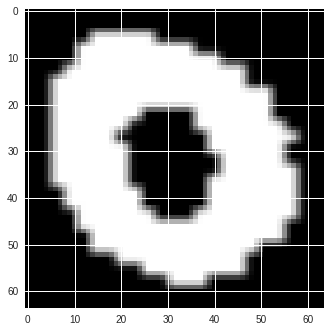

In [7]:

X_data_processed = pre_process_images(X_data)
plt.imshow(X_data_processed[2])

In [8]:
X_data_processed2 = X_data_processed[:, :, :, 0].reshape(X_data_processed.shape[0], 64, 64, 1)
y_data = keras.utils.to_categorical(y_data['Category'])

X_data_processed2.shape

(40000, 64, 64, 1)

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_data_processed2, y_data, test_size=0.2, random_state=42)

num_classes = 10
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, Adadelta

import keras
input_shape = (64,64,1)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
'''
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer = Adam(lr=1e-3),
              metrics=['accuracy'])
'''

print(model.summary())



In [22]:
epochs = 30
batch_size = 128
num_steps= 1000


data_generator = ImageDataGenerator(rotation_range=20,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.1,
                                    zoom_range=0.1)

model.fit_generator(data_generator.flow(X_train, y_train,batch_size=batch_size),
          epochs=epochs,
          verbose=1,
          steps_per_epoch=num_steps,
       validation_data=(X_val,y_val))
'''
model.fit_generator((X_train, y_train),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          steps_per_epoch=num_steps,
          validation_data=(X_val,y_val))'''

Epoch 1/30
1000/1000 [==============================] - 105s 105ms/step - loss: 0.6677 - acc: 0.8106 - val_loss: 0.5435 - val_acc: 0.8417
Epoch 2/30
 710/1000 [====================>.........] - ETA: 30s - loss: 0.6265 - acc: 0.8237

KeyboardInterrupt: ignored

In [16]:

X_test_processed = pre_process_images(X_test)
X_test_processed2 = X_test_processed[:,:,:,0].reshape(X_test_processed.shape[0], 64, 64, 1)
print(X_test_processed2.shape)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0
5000
(10000, 64, 64, 1)


In [0]:
predictions = model.predict_classes(X_test_processed2, verbose=2)
pd.DataFrame(predictions).to_csv("mnist.csv", header=['Category'], index_label='Id')
pd.DataFrame(predictions).to_csv("gdrive/My Drive/data/mnist.csv", header=['Category'], index_label='Id')
